In [46]:
%cd /home/dongmin/23FW-NCG/jeongganbo-omr
%load_ext autoreload
%autoreload 2

/home/dongmin/userdata/jeongganbo-omr
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from time import time
import csv
import re
import glob
import json
from random import randint, choice, uniform
import pickle
from pathlib import Path

from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt

from exp_utils import JeongganSynthesizer, get_img_paths

dprint = lambda d: print(json.dumps(d, indent=2))

# Jng Synthesizer

## PATHS

임:1 니느라니:2 노:3 무:4 네로나:6 니로나:7 겹요성표:8 니레나:9


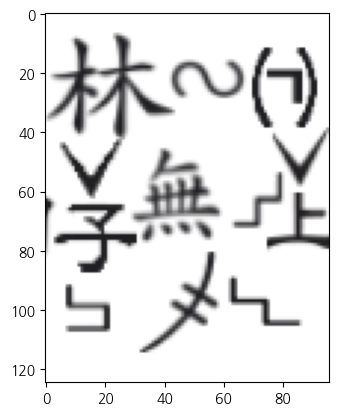

In [110]:
jng_img_path_dict = get_img_paths('test/synth/src', ['notes', 'symbols'])
jng_synth = JeongganSynthesizer(jng_img_path_dict)

settings = {
  'apply_noise': True,
  'random_symbols': True,
  'layout_elements': False,
}

label, jng_img = jng_synth(**settings)

print(label)
plt.imshow(jng_img)

## test

### random 30 plot

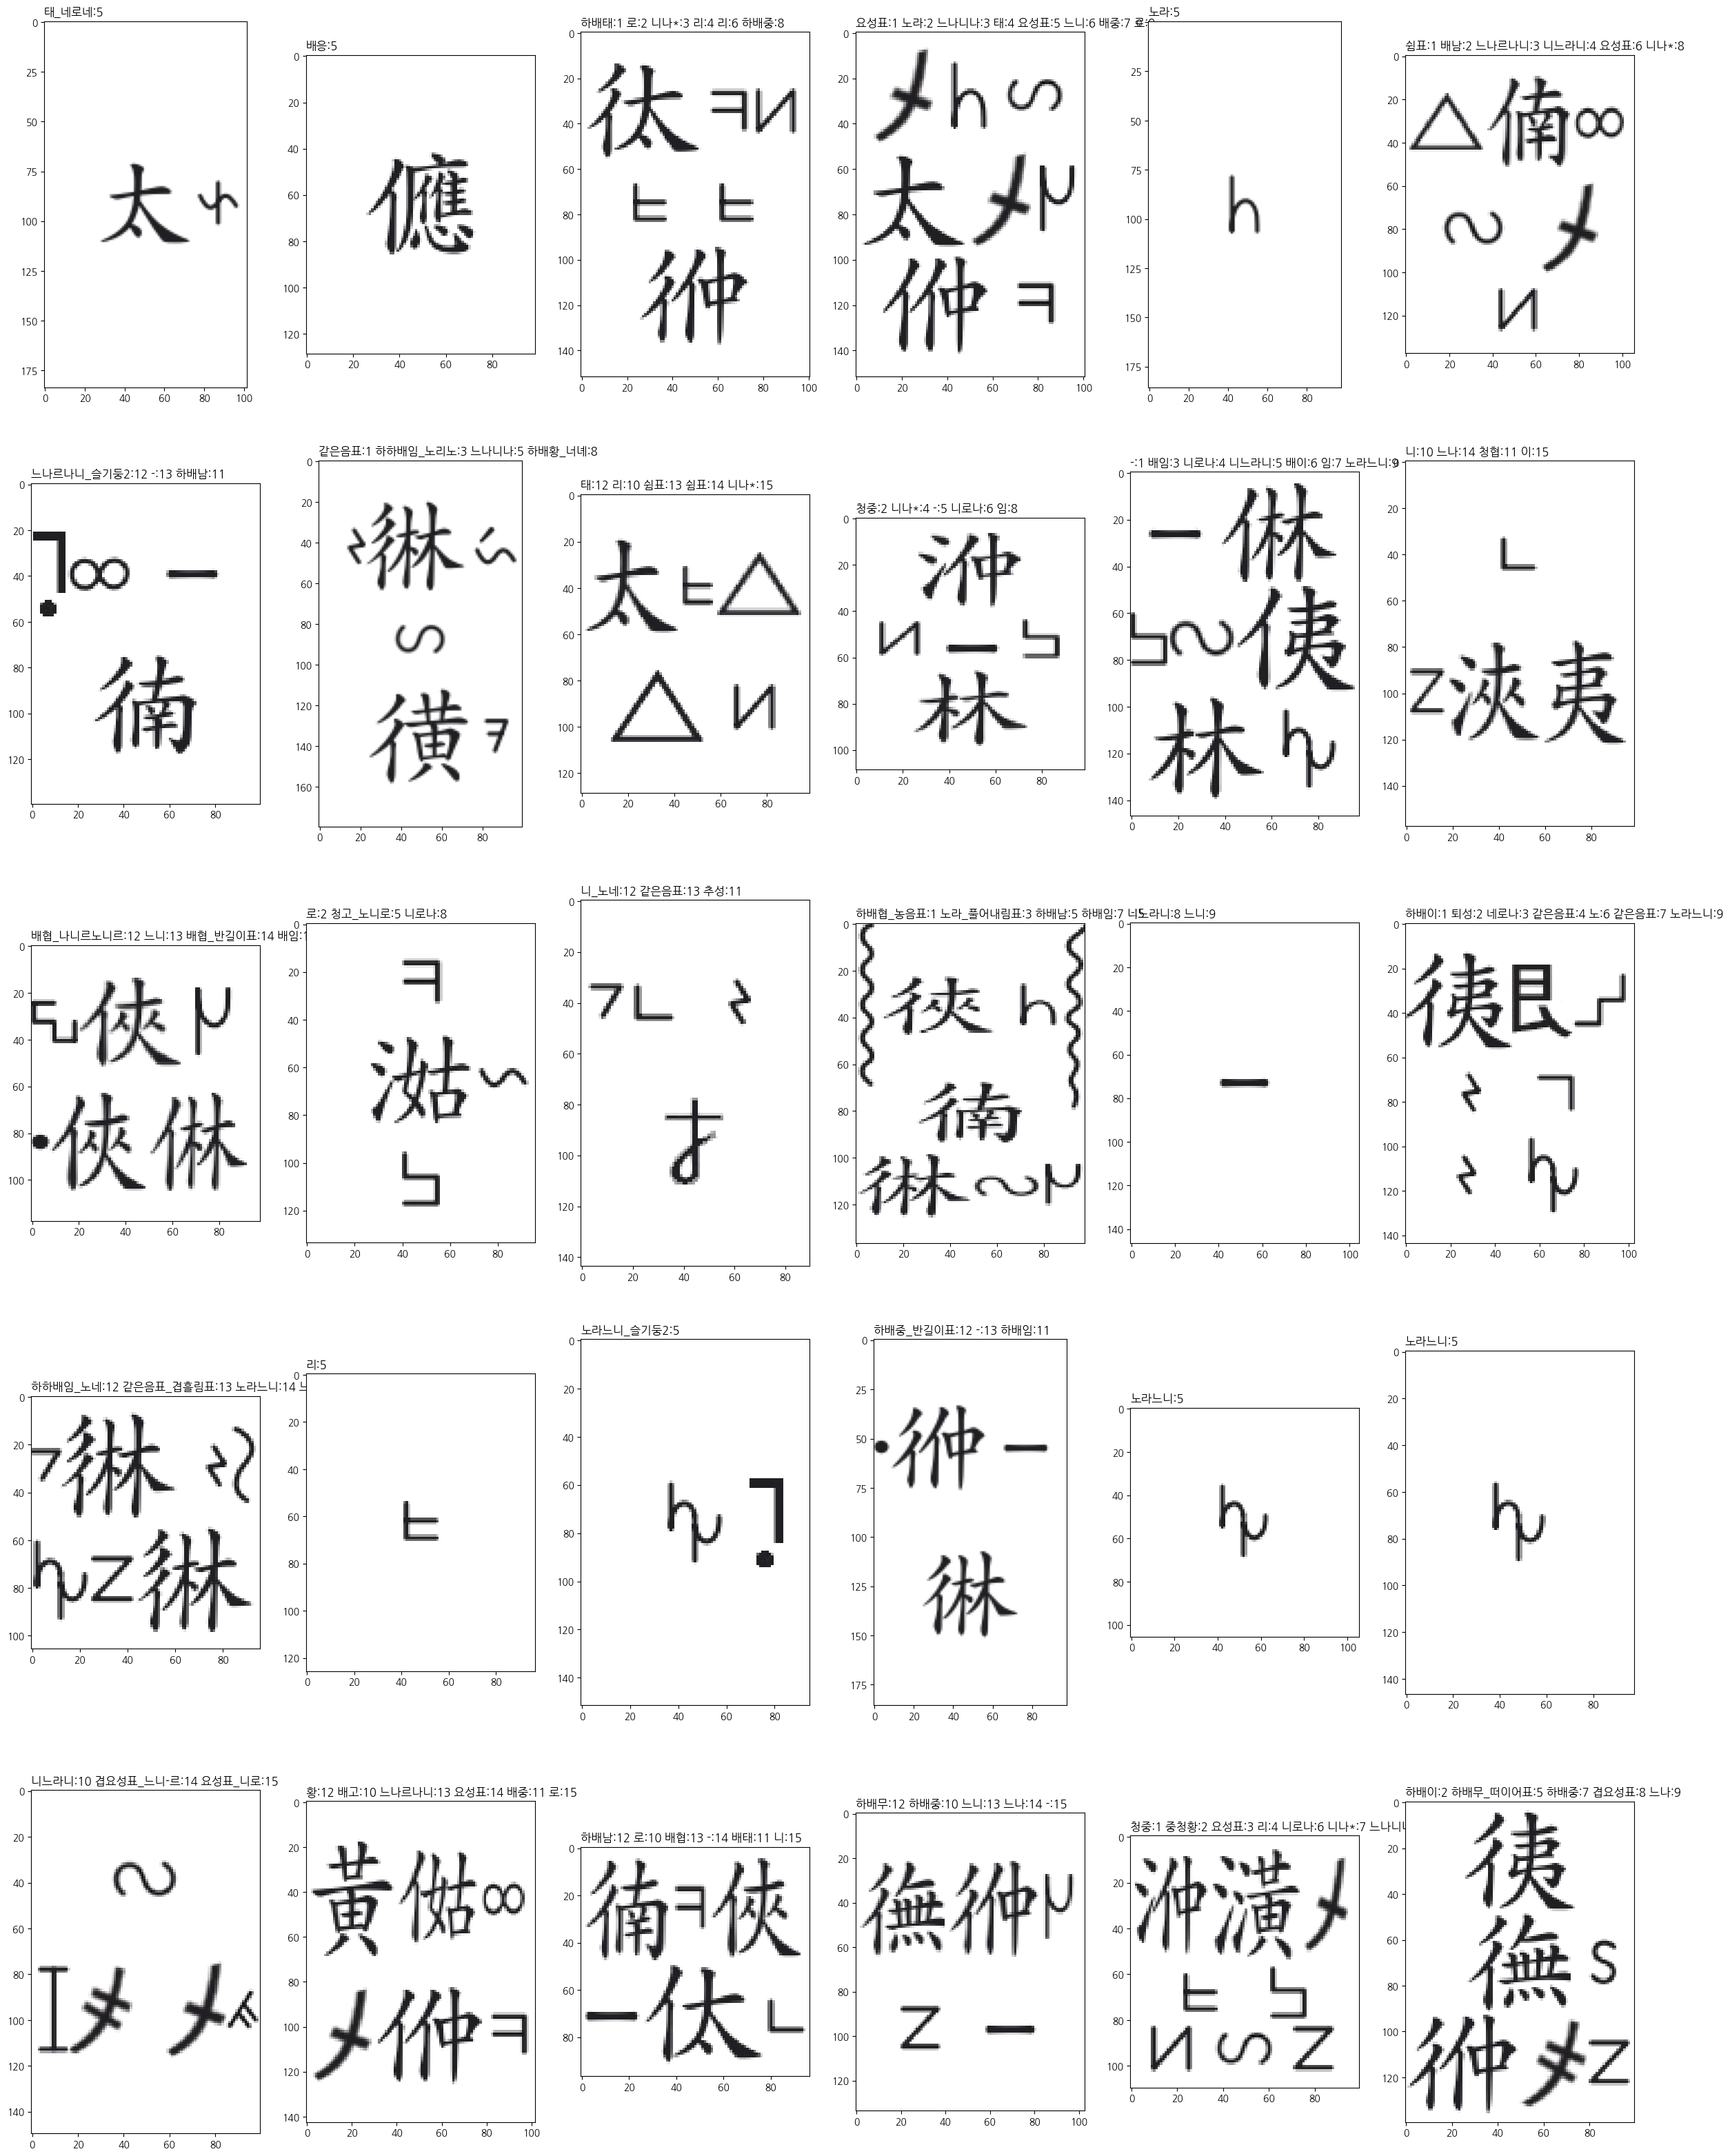

In [111]:
settings = {
  'apply_noise': False,
  'random_symbols': False,
  'layout_elements': False,
}

plt.rcParams.update({'font.family': 'NanumGothic'})
plt.figure(figsize=(30, 40))

for idx in range(1, 31):
  label, img = jng_synth(**settings)
  
  plt.subplot(5, 6, idx)
  plt.imshow(img)
  plt.title(label, loc='left')

### random 30 from test set

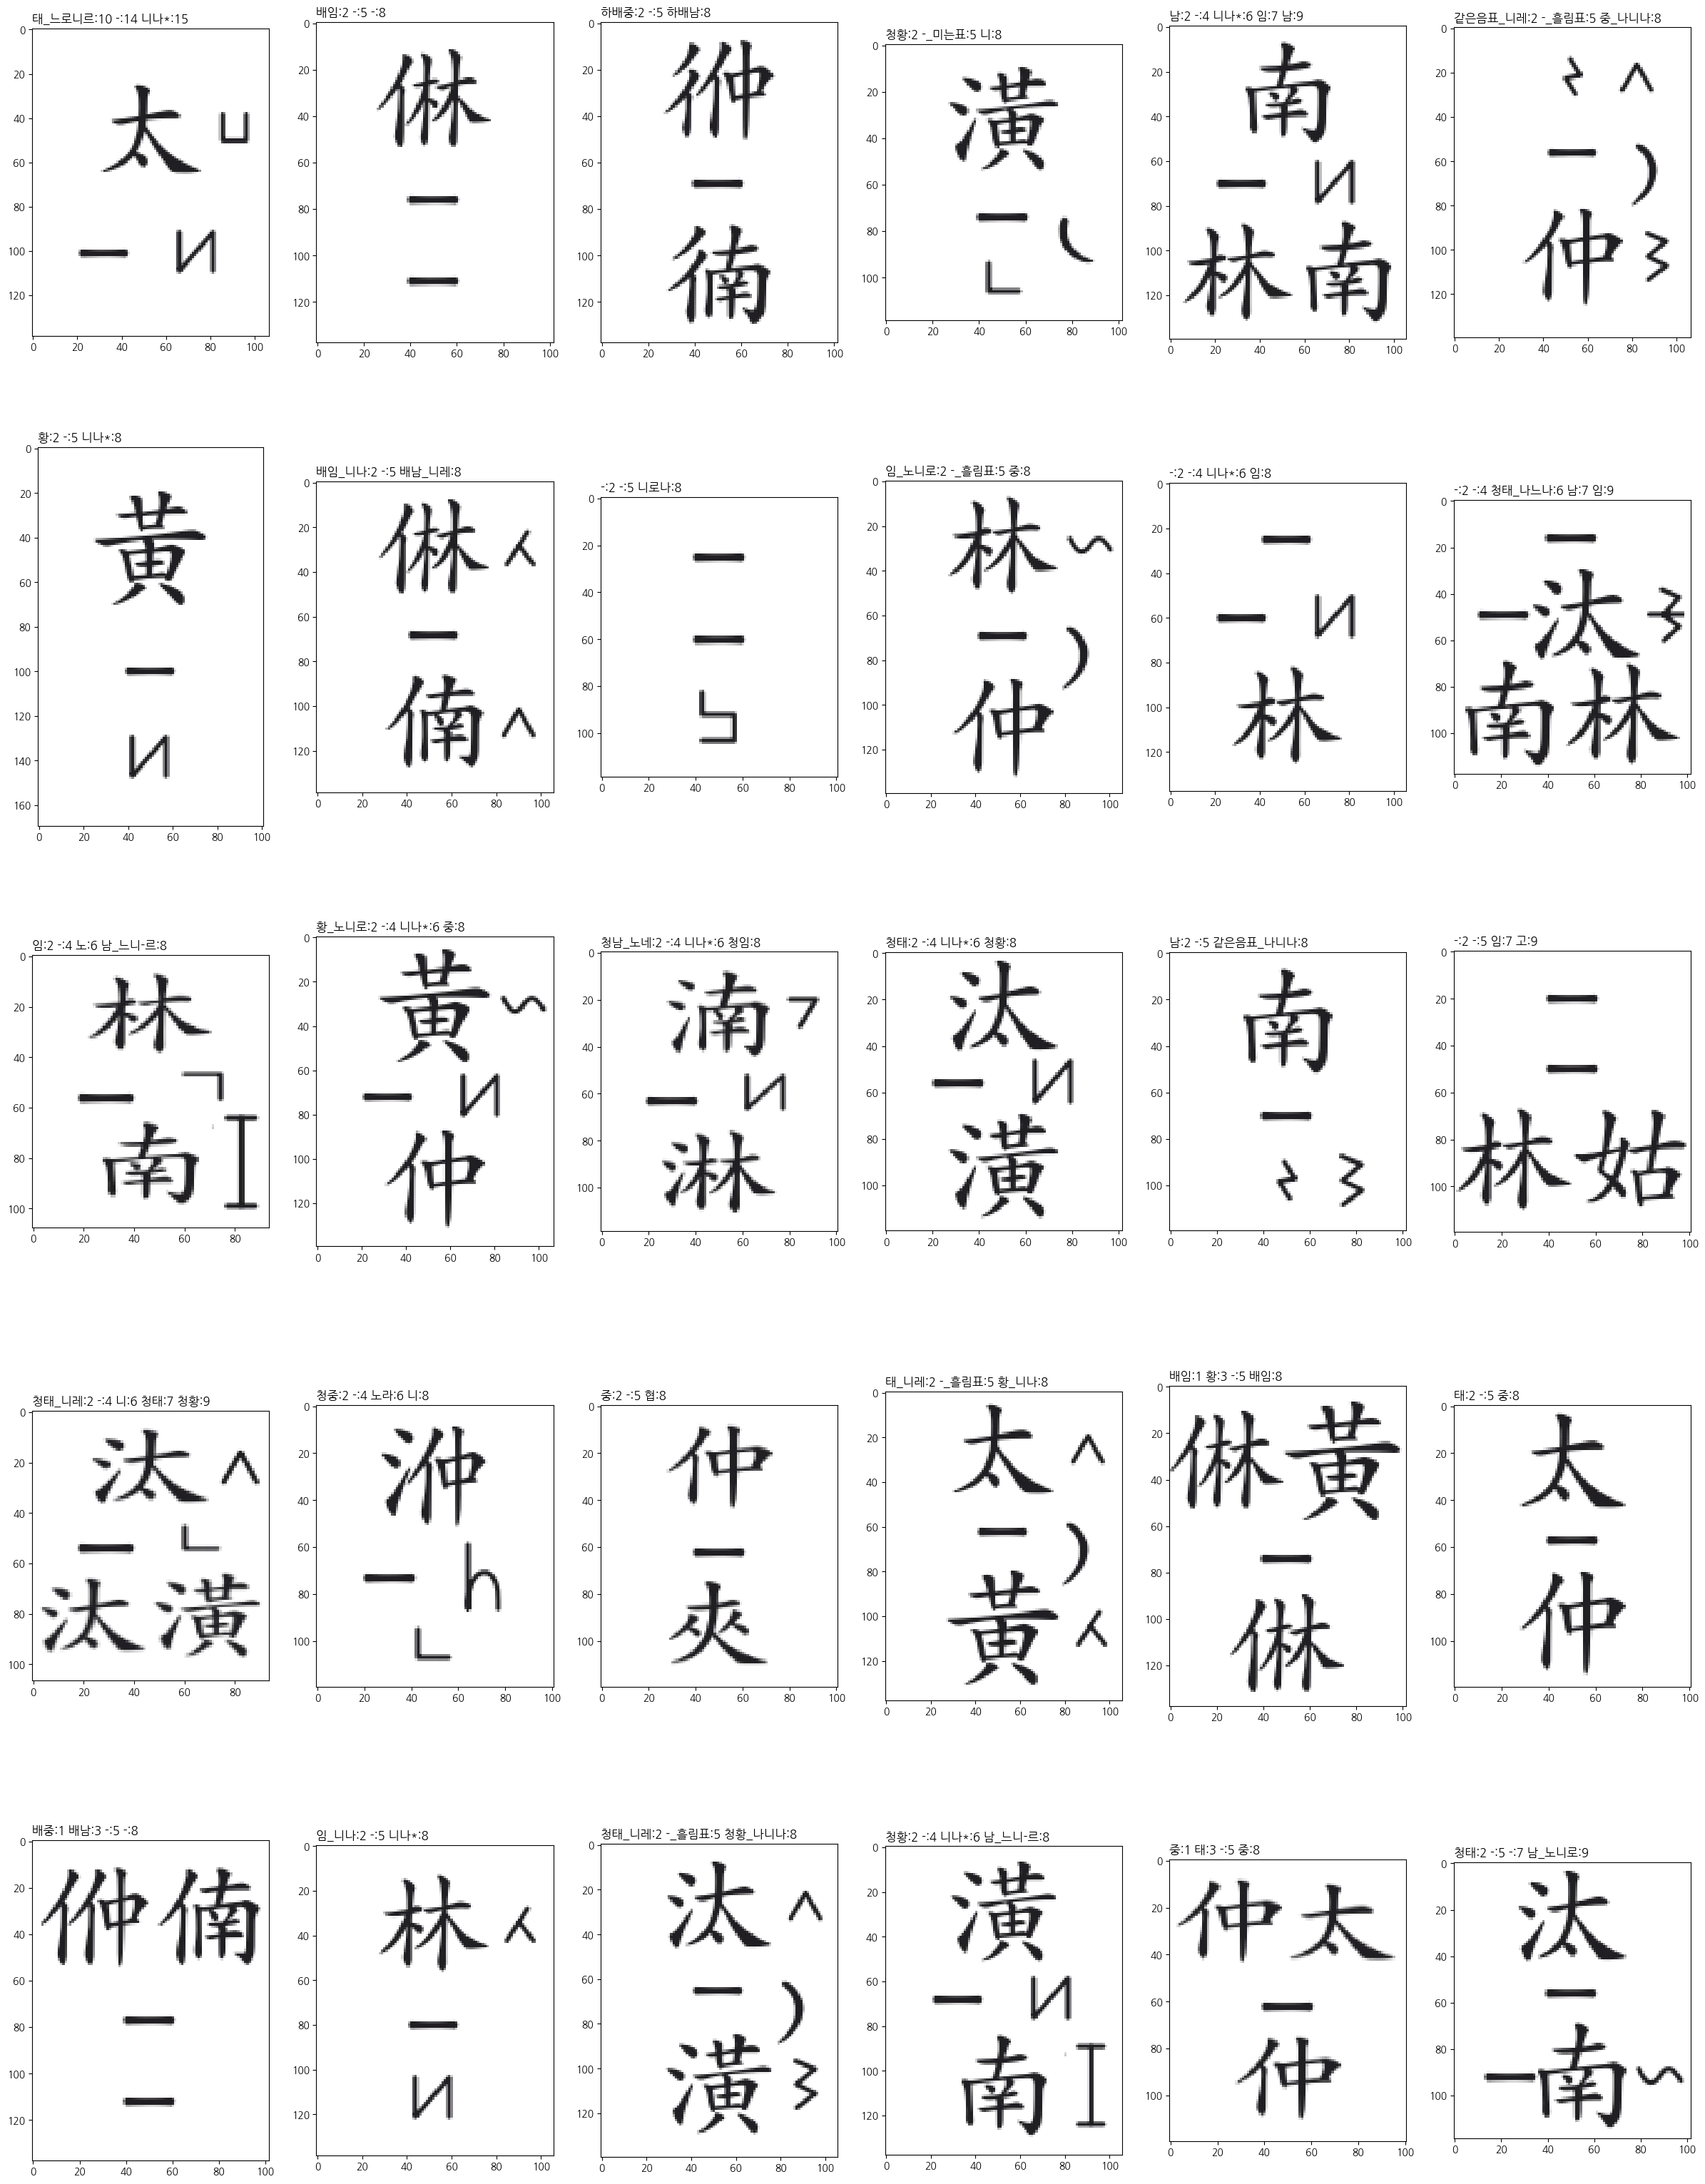

In [109]:
with open('labels_from_ls_cleaned.csv') as f:
  test_data = csv.reader(f)
  test_data = filter(lambda x: 'haegeum' not in x[0] and 'piri' not in x[0] and 'geomungo' not in x[0] and ' -' in x[1], test_data)
  test_data = list(test_data)

settings = {
  'apply_noise': False,
  'random_symbols': False,
  'layout_elements': False,
}

plt.rcParams.update({'font.family': 'NanumGothic'})
plt.figure(figsize=(30, 40))

for idx in range(1, 31):
  filename, label = choice(test_data)
  
  img_h, img_w = cv2.imread( str(Path('test/split_pngs') / filename) ).shape[:2]
  
  img = jng_synth.generate_image_by_label(label, img_w, img_h, **settings)
  plt.subplot(5, 6, idx)
  plt.imshow(img)
  plt.title(label, loc='left')

### stress test

In [27]:
import sys

NUM = 100_000

settings = {
  'apply_noise': True,
  'random_symbols': True
}

exceptions = []

for _ in tqdm(range(NUM), leave=False):
  while True:
    try:
      label, jng_img = jng_synth(**settings)
      break
    except Exception as e:
      exceptions.append((e, sys.exc_info()))

len(exceptions)

4

In [28]:
exceptions

[(cv2.error("OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4158: error: (-215:Assertion failed) !dsize.empty() in function 'resize'\n"),
  (cv2.error,
   cv2.error("OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4158: error: (-215:Assertion failed) !dsize.empty() in function 'resize'\n"),
   <traceback at 0x7756817b5c80>)),
 (cv2.error("OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4158: error: (-215:Assertion failed) !dsize.empty() in function 'resize'\n"),
  (cv2.error,
   cv2.error("OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4158: error: (-215:Assertion failed) !dsize.empty() in function 'resize'\n"),
   <traceback at 0x7756817bc0c0>)),
 (cv2.error("OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4158: error: (-215:Assertion failed) !dsize.empty() in function 'resize'\n"),
  (cv2.error,
   cv2.error("OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4158: error: (-215:Assertion failed) !dsize.empty() in function 'resize'\n"),
 

In [29]:
import traceback

traceback.print_exception(*exceptions[0][1])

Traceback (most recent call last):
  File "/tmp/ipykernel_100576/3642462241.py", line 15, in <module>
    label, jng_img = jng_synth(**settings)
  File "/home/dongmin/userdata/jeongganbo-omr/exp_utils/jeonggan_synthesizer.py", line 56, in __call__
    label, *_, jng_img = self.generate_single_data(range_limit=range_limit, ornaments=ornaments, apply_noise=apply_noise, random_symbols=random_symbols, layout_elements=layout_elements)
  File "/home/dongmin/userdata/jeongganbo-omr/exp_utils/jeonggan_synthesizer.py", line 65, in generate_single_data
    jng_img = self.generate_image_by_label(label, img_w, img_h, apply_noise=apply_noise, random_symbols=random_symbols, layout_elements=layout_elements)
  File "/home/dongmin/userdata/jeongganbo-omr/exp_utils/jeonggan_synthesizer.py", line 170, in generate_image_by_label
    jng_img = self.generate_image_by_dict(img, jng_dict, apply_noise=apply_noise, random_symbols=random_symbols)
  File "/home/dongmin/userdata/jeongganbo-omr/exp_utils/jeonggan_s

### reconstruction test

In [112]:
test_data_filename = 'labels_from_ls_cleaned.csv'

with open(f'{test_data_filename}') as f:
  test_data = list(csv.reader(f))

len(test_data)

1816

failed:  8


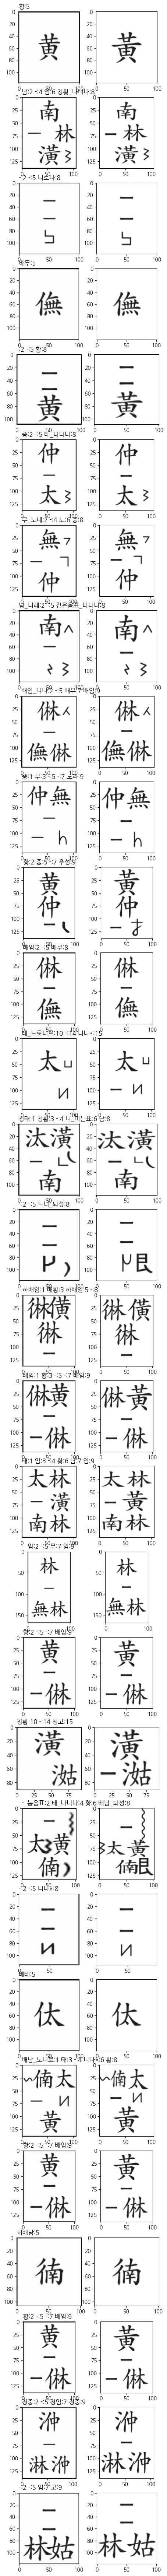

In [117]:
# Start index, if START == NONE: idx = choice()
START = None # 90
NUM = 30

self = jng_synth

settings = {
  'apply_noise': False,
  'random_symbols': False,
  'layout_elements': False,
}

res = []
failed = []

cnt = 0
while True:
  data = test_data[START + cnt] if isinstance(START, int) else choice(test_data)
  filename, label = data
  
  try:
    img_og = cv2.imread(f'test/split_pngs/{filename}')
    img_h, img_w = img_og.shape[:2]
    
    img = self.generate_image_by_label(label, img_w, img_h, **settings)
    
    res.append((label, img_og, img))
    
  except:
    failed.append((filename, label))
  
  cnt += 1
  
  if len(res) == NUM:
    break

print('failed: ', len(failed))

plt.rcParams.update({'font.family': 'NanumGothic'})
plt.figure(figsize=(5, 90))

idx = 1

for label, og, synth in res:
  plt.subplot(30, 2, idx)
  plt.imshow(og)
  plt.title(label, loc='left')
  idx+=1
  
  plt.subplot(30, 2, idx)
  plt.imshow(synth)
  idx+=1

In [118]:
failed

[(61, '남창우조-소용이_geomungo_52.png', '배중_퇴성_9:2 추성:5 -:8'),
 (61, '남창계면-이수대엽_geomungo_58.png', '배중_뜰:2 퇴성:5 -:8'),
 (61, '여민락_geomungo_378.png', '하배임_중현:5'),
 (61, '남창계면-두거_geomungo_136.png', '배임_살갱:2 -:5 -:8'),
 (61, '여민락_piri_1075.png', '퇴성_루러표:5'),
 (61, '여창계면-중거_haegeum_237.png', '배임:2 황_4:5 -:8'),
 (61, '남창계면-이수대엽_haegeum_171.png', '배임:2 황_4:5 -:8'),
 (61, '남창계면-이수대엽_geomungo_151.png', '배황:2 배황_대현:5 -:8')]